In [1]:
from prometheus_api_client import PrometheusConnect, MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime
import pandas as pd
import pendulum
from greenflow.g import g
from tinydb import TinyDB, Query
from os import getenv

url = getenv("PROMETHEUS_URL")
prom = PrometheusConnect(url=url)


In [2]:
experiments = {exp.doc_id: exp for exp in g.storage.experiments.all()}

def sort_by_time(exp_id):
    date_time_str = experiments[exp_id]["started_ts"]
    return pendulum.parse(date_time_str)

In [3]:
exp_ids = sorted(
    experiments.keys(),
    key=sort_by_time,
    reverse=True,
)
results = []

for index, _ in enumerate(exp_ids):
    current = exp_ids[index]
    started_ts_string = experiments[current]["started_ts"]
    stopped_ts_string = experiments[current]["stopped_ts"]
    started_ts = pendulum.parse(started_ts_string)
    stopped_ts = pendulum.parse(stopped_ts_string)
    metadata = experiments[current]["experiment_metadata"]
    params = dict(**metadata["factors"]["exp_params"])
    # select just the relevant params - load, instances, durationSeconds
    params = {
        k: v for k, v in params.items() if k in ["load", "instances", "durationSeconds"]
    }
    if "results" in metadata:
        result = metadata["results"]
    else:
        result = {}
    current_result = {
        "exp_id": current,
        "exp_name": experiments[current]["exp_name"],
        "started_ts": started_ts_string,
        "stopped_ts": stopped_ts_string,
        "duration_from_ts": stopped_ts.diff(started_ts).in_seconds(),
        "dashboard_url": metadata["dashboard_url"],
        **result,
        **params,
    }

    if started_ts > pendulum.now().subtract(days=3):
        results.append(current_result)

results = pd.DataFrame(results)
# Reindex with exp_id
results = results.set_index("exp_id")
# print(results[:25].to_csv())
redpanda_kafka_data = results

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in the 'redpanda_kafka_data' DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid

# Filter out start and stop times
# redpanda_kafka_data = redpanda_kafka_data.drop(columns=['started_ts', 'stopped_ts'])
redpanda_kafka_data['load'] = pd.to_numeric(redpanda_kafka_data['load'], errors='coerce')
redpanda_kafka_data['total_host_energy'] = pd.to_numeric(redpanda_kafka_data['total_host_energy'], errors='coerce')
redpanda_kafka_data.loc[redpanda_kafka_data['duration'] < 5, 'duration'] = 330 + redpanda_kafka_data['duration']
redpanda_kafka_data['avg_host_power'] = redpanda_kafka_data['total_host_energy'] / redpanda_kafka_data['durationSeconds'] / 3
redpanda_kafka_data = redpanda_kafka_data[redpanda_kafka_data['avg_host_power'] <= 100]
redpanda_kafka_data = redpanda_kafka_data[redpanda_kafka_data['avg_host_power'] >= 40]




# Display DataFrame using qgrid (Assuming your DataFrame is 'redpanda_kafka_data')
qgrid_widget = qgrid.show_grid(redpanda_kafka_data, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

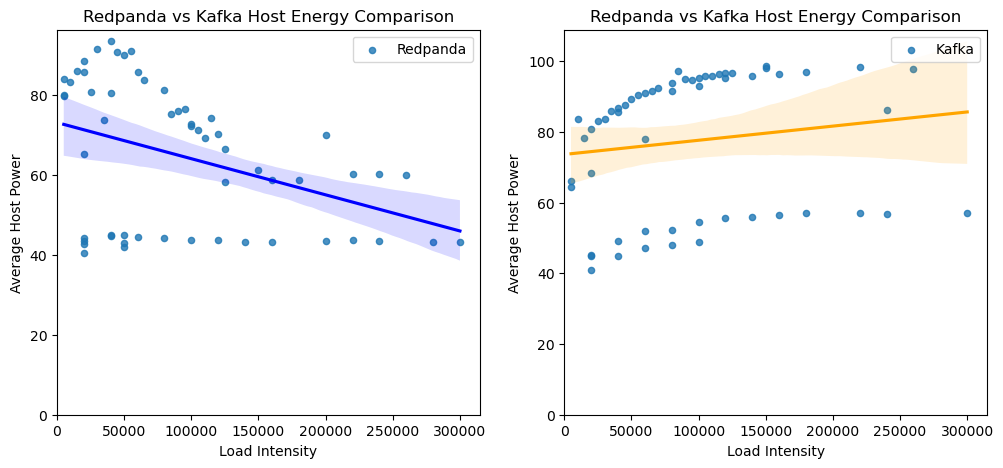

In [5]:
redpanda_kafka_data = qgrid_widget.get_changed_df()
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# fig, ax = plt.subplots(figsize=(12, 5))

# Plot Redpanda data
sns.regplot(x='load', y='avg_host_power', data=redpanda_kafka_data[redpanda_kafka_data['exp_name'] == 'ingest-redpanda'], 
            scatter_kws={'s': 20}, line_kws={'color': 'blue'}, label='Redpanda', ax=ax1)

# Plot Kafka data
sns.regplot(x='load', y='avg_host_power', data=redpanda_kafka_data[redpanda_kafka_data['exp_name'] == 'ingest-kafka'],
            scatter_kws={'s': 20}, line_kws={'color': 'orange'}, label='Kafka', ax=ax2)

for ax in [ax1,ax2]:
    ax.set_title('Redpanda vs Kafka Host Energy Comparison')
    ax.set_xlabel('Load Intensity')
    ax.set_ylabel('Average Host Power')

    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    ax.legend()

# Show the plot
plt.show()


# Plot Redpanda data on the first subplot
# sns.regplot(x='load', y='avg_host_power', data=redpanda_kafka_data[redpanda_kafka_data['exp_name'] == 'ingest-redpanda'], 
#             ax=ax1, scatter_kws={'s': 80}, line_kws={'color': 'blue'})
# ax1.set_title('Redpanda')
# ax1.set_xlabel('Load Intensity')
# ax1.set_ylabel('Total Host Energy')

# # Plot Kafka data on the second subplot
# sns.regplot(x='load', y='avg_host_power', data=redpanda_kafka_data[redpanda_kafka_data['exp_name'] == 'ingest-kafka'],
#             ax=ax2, scatter_kws={'s': 80}, line_kws={'color': 'orange'})
# ax2.set_title('Kafka')
# ax2.set_xlabel('Load Intensity')
# ax2.set_ylabel('Average Host Power')

# # Adjust spacing between subplots
# plt.subplots_adjust(wspace=0.3)

# # Show the plot
# plt.show()